In [1]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
train_data_path = "./CamVid/train/"
train_labels_path = "./CamVid/trainannot/"

In [3]:
import os

In [4]:
os.listdir(train_data_path)

['0001TP_006960.png',
 '0001TP_006930.png',
 '0001TP_006900.png',
 '0001TP_006810.png',
 '0001TP_006720.png',
 '0001TP_006690.png',
 '0001TP_006840.png',
 '0001TP_006870.png',
 '0001TP_006780.png',
 '0001TP_006750.png']

In [5]:
len(os.listdir(train_labels_path))

10

In [6]:
print(os.listdir(train_data_path)[7]==os.listdir(train_labels_path)[7])

True


In [7]:
def normalized(rgb):
    #return rgb/255.0
    norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    b=rgb[:,:,0]
    g=rgb[:,:,1]
    r=rgb[:,:,2]

    norm[:,:,0]=cv2.equalizeHist(b)
    norm[:,:,1]=cv2.equalizeHist(g)
    norm[:,:,2]=cv2.equalizeHist(r)

    return norm

In [8]:
def one_hot_it(labels):
    x = np.zeros([360,480,12])
    for i in range(360):
        for j in range(480):
            x[i,j,labels[i][j]]=1
    return x

In [ ]:
'''def generate_data(data_path,labels_path,batch_size):
    
    data_file_list = os.listdir(data_path)
    labels_file_list = os.listdir(labels_path) 
    i = 0
    while True:
        batch_data = []
        batch_labels = []
        print(i)
        j=0
        for j in range(i,i+batch_size):
            batch_data.append(np.rollaxis(normalized(cv2.imread(data_path + data_file_list[j])),2))
            batch_labels.append(one_hot_it(cv2.imread(labels_path + labels_file_list[j])))
                                
            j = j + 1
            print(j)
            
        i = i+batch_size
        print(i)
        batch_data = np.array(batch_data)
        batch_labels = np.array(batch_labels)
        batch_labels = np.reshape(batch_labels,(batch_size,data_shape,12))
        print(batch_data.shape)
        print(batch_labels.shape)
        yield batch_data,batch_labels
        
        '''
    

In [26]:
def generate_data(data_path,labels_path,batch_size):
    
    data_file_list = os.listdir(data_path)
    labels_file_list = os.listdir(labels_path) 
    i = 0
    while True:
        batch_data = []
        batch_labels = []
        #print(i)
        j=0
        for b in range(batch_size):
            if i==len(data_file_list):
                i=0
            '''if data_file_list[i]==labels_file_list[i]:
                 print(True)
            else:
                 print(False)'''
            image_path = data_path + data_file_list[i]
            label_path = labels_path + labels_file_list[i]
            batch_data.append(np.rollaxis(normalized(cv2.imread(image_path)),2))
            batch_labels.append(one_hot_it(cv2.imread(label_path)))
            i+=1                    
            
        #print(i)
        batch_data = np.array(batch_data)
        batch_labels = np.array(batch_labels)
        batch_labels = np.reshape(batch_labels,(batch_size,data_shape,12))
        #print(batch_data.shape)
        #print(batch_labels.shape)
        yield batch_data,batch_labels
    

In [16]:
import keras
from keras import models

/home/bsrivats/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
with open('my_model_monday.json') as model_file:
    segnet_basic = models.model_from_json(model_file.read())


In [30]:
train_data_gen = generate_data("./CamVid/train/","./CamVid/trainannot/",1)

In [31]:
val_data_gen = generate_data("./CamVid/val/","./CamVid/valannot/",1)

In [20]:
segnet_basic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_3 (Layer)              (None, 3, 360, 480)       0         
_________________________________________________________________
zero_padding2d_17 (ZeroPaddi (None, 3, 362, 482)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 360, 480)      1792      
_________________________________________________________________
batch_normalization_17 (Batc (None, 64, 360, 480)      1920      
_________________________________________________________________
activation_13 (Activation)   (None, 64, 360, 480)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 180, 240)      0         
_________________________________________________________________
zero_padding2d_18 (ZeroPaddi (None, 64, 182, 242)      0         
__________

In [21]:
segnet_basic.compile(loss="categorical_crossentropy", optimizer='adadelta', metrics=["accuracy"])

In [22]:
from keras.callbacks import ModelCheckpoint

In [23]:
filepath="weights/weights_image_data_gen.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [24]:
data_shape = 360*480
class_weighting= [0.2595, 0.1826, 4.5640, 0.1417, 0.5051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]


In [32]:
history = segnet_basic.fit_generator(train_data_gen,steps_per_epoch=10,epochs=8,verbose=1,callbacks=callbacks_list,validation_data=val_data_gen,validation_steps=10,class_weight=class_weighting,shuffle=True,initial_epoch=0)

Epoch 1/8
10/10 [==============================] - 137s 14s/step - loss: 2.8473 - acc: 0.2177 - val_loss: 2.4004 - val_acc: 0.2991

Epoch 00001: val_acc improved from -inf to 0.29906, saving model to weights/weights_image_data_gen.best.hdf5
Epoch 2/8
10/10 [==============================] - 132s 13s/step - loss: 1.9234 - acc: 0.2756 - val_loss: 2.3199 - val_acc: 0.3055

Epoch 00002: val_acc improved from 0.29906 to 0.30551, saving model to weights/weights_image_data_gen.best.hdf5
Epoch 3/8
10/10 [==============================] - 133s 13s/step - loss: 1.9221 - acc: 0.2736 - val_loss: 2.2679 - val_acc: 0.3098

Epoch 00003: val_acc improved from 0.30551 to 0.30978, saving model to weights/weights_image_data_gen.best.hdf5
Epoch 4/8
10/10 [==============================] - 132s 13s/step - loss: 1.8996 - acc: 0.2815 - val_loss: 2.2696 - val_acc: 0.3133

Epoch 00004: val_acc improved from 0.30978 to 0.31332, saving model to weights/weights_image_data_gen.best.hdf5
Epoch 5/8
10/10 [==========

In [33]:
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb


In [34]:
import os
DataPath = './CamVid/'

gt = []
with open(DataPath+'train.txt') as f:
    txt = f.readlines()
    txt = [line.split(' ') for line in txt]
for i in range(len(txt)):
    gt.append(cv2.imread(os.getcwd() + txt[i][0][7:]))

In [50]:
os.listdir(DataPath+"train")

['0001TP_006960.png',
 '0001TP_006930.png',
 '0001TP_006900.png',
 '0001TP_006810.png',
 '0001TP_006720.png',
 '0001TP_006690.png',
 '0001TP_006840.png',
 '0001TP_006870.png',
 '0001TP_006780.png',
 '0001TP_006750.png']

In [51]:
image_path  = os.listdir(DataPath+"train")[9]
print(image_path)
print(DataPath+"train/"+image_path)

0001TP_006750.png
./CamVid/train/0001TP_006750.png


In [52]:
data= []
data.append(np.rollaxis(normalized(cv2.imread(DataPath+"train/"+image_path)),2))
data = np.array(data)
print(data.shape)

(1, 3, 360, 480)


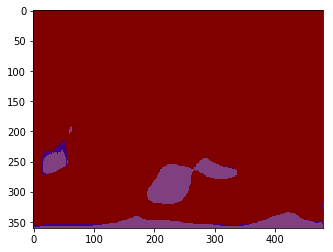

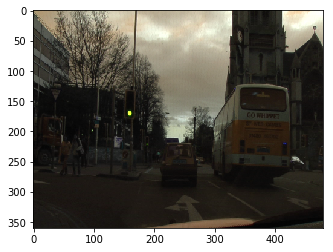

In [53]:
output = segnet_basic.predict_proba(data[0:1])
pred = visualize(np.argmax(output[0],axis=1).reshape((360,480)), False)
plt.imshow(pred)
plt.figure(2)
plt.imshow(gt[9])